In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gc

In [3]:
df = pd.read_csv('/content/drive/Shareddrives/Machine Learning Final Project/data/malicious_urls.csv')
df['type'].value_counts()
mal_type = {'benign': 0, 'defacement': 1, 'phishing': 1, 'malware': 1}
df['label'] = [mal_type[item] for item in df['type']]
df

,url,type,label
0,br-icloud.com.br,phishing,1
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,1
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,1
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,1


In [4]:
#Character Embeddings
import math
import string
from keras.preprocessing.text import Tokenizer
max_length = df.url.map(len).max()
df['url'] = df['url'].str.lower()
converter = Tokenizer(num_words=None, char_level=True, oov_token='extra')
letter_dict = dict(zip(string.ascii_lowercase+string.punctuation, [i for i in range(58)]))
converter.word_index = letter_dict.copy()
converter.word_index[converter.oov_token] = max(letter_dict.values()) + 1
labels = df['label']
X_train, X_test, y_train, y_test = train_test_split(df['url'].tolist(), labels, test_size=0.33, random_state=42)
sequences = converter.texts_to_sequences(df['url'])
X_train = np.array( converter.texts_to_sequences(X_train) )
X_test  = np.array( converter.texts_to_sequences(X_test))
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
print(df['url'][0])
print(X_train[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


br-icloud.com.br
[ 7 19 19 ...  0  0  0]


In [5]:
max_length

2175

In [ ]:
max_features = 59
embedding_dim = 64
sequence_length = max_length
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(59 +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    
model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2175, 64)          3840      
                                                                 
 conv1d (Conv1D)             (None, 2173, 128)         24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 28,673
Trainable params: 28,673
Non-trainable params: 0
____________________________________________________

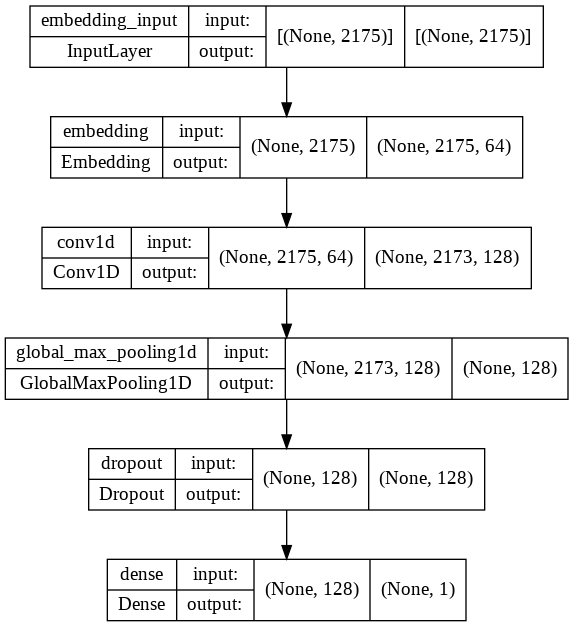

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, validation_split = 0.33, epochs = 4, batch_size = 1024)

In [ ]:
from sklearn.metrics import confusion_matrix
label_predict = model.predict(X_test)
rounded = (label_predict  > 0.5).astype(int)
scores = model.evaluate(X_test,y_test)

In [ ]:
print(classification_report(y_test, rounded, target_names=['Benign', 'Defacement', 'Phishing', 'Malware']))

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()